In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np


### Params

In [3]:
b,w,h = 2,20,20
prob_corr_factor = 0.23
n_objects_max = 20
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
from MODULES.utilities_ml import FiniteDPP, SimilarityKernel


In [38]:
list_of_output = []
list_of_input = []
w_list = [0.1, 1, 0.1, 1]
l_list = [10, 10, 0.1, 0.1]
for l,w in zip(l_list,w_list):

    similarity = SimilarityKernel(n_kernels=1, 
                                  length_scales=l*torch.ones(1),
                                  kernel_weights=w*torch.ones(1))
    L = similarity(n_width=20, n_height=20)
    DPP = FiniteDPP(L=L)
    value = DPP.sample(sample_shape=torch.Size([3]))
    mask = similarity.sample_2_mask(value)

    my_input = (similarity.get_l_w()[0].item(), similarity.get_l_w()[1].item())
    print("l,w ->",my_input)
    list_of_input.append(my_input)
    list_of_output.append(mask)

l,w -> (10.010000228881836, 0.11000004410743713)
l,w -> (10.010000228881836, 1.0099999904632568)
l,w -> (0.11000004410743713, 0.11000004410743713)
l,w -> (0.11000004410743713, 1.0099999904632568)


(0.11000004410743713, 1.0099999904632568)


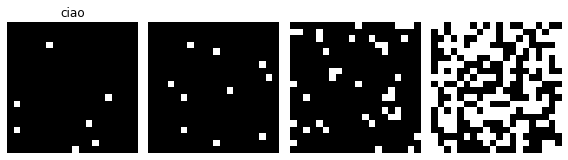

In [44]:
print(list_of_input[-1])

print()
mask = list_of_output[-1]

fig, ax =  plt.subplots(ncols=4, figsize=(8,8))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[0].imshow(list_of_output[0][0], cmap='gray')
ax[1].imshow(list_of_output[1][0], cmap='gray')
ax[2].imshow(list_of_output[2][0], cmap='gray')
ax[3].imshow(list_of_output[3][0], cmap='gray')
fig.tight_layout()
fig.savefig("./DPP_samples.png")

In [ ]:
similarity.get_sigma2_w()[0].item()
similarity.get_sigma2_w()[1].item()


In [ ]:
dict_of_mask[(tensor([1.]),
  tensor([10.]))]

In [ ]:
print(similarity.similarity_s2)
print(similarity.get_sigma2_w())

In [ ]:


print(log_p)
plt.rcParams["axes.grid"] = False

fig, ax =  plt.subplots(ncols=2, nrows=2, figsize=(8,8))
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[0,0].imshow(mask[0], cmap='gray')
ax[0,1].imshow(mask[1], cmap='gray')
ax[1,0].imshow(mask[2], cmap='gray')
ax[1,1].imshow(mask.sum(dim=(-3)), cmap='gray')

In [ ]:
OLD_log_p = DPP.OLD_log_prob(value)
print(OLD_log_p)

In [ ]:
log_p = DPP.log_prob(value)
print(log_p)

In [ ]:
print(similarity.similarity_s2.grad)
print(similarity.similarity_w.grad)
log_p.sum().backward()
print(similarity.similarity_s2.grad)
print(similarity.similarity_w.grad)

### GUIDE

In [ ]:
class PassBernoulli(torch.autograd.Function):
    @staticmethod
    def forward(ctx, p):
        c = torch.rand_like(p)<p
        return c
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def pass_bernoulli(prob):
    return PassBernoulli.apply(prob)
    
class PassMask(torch.autograd.Function):
    @staticmethod
    def forward(ctx, c, mask):
        return c*nms_mask
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output
    
def pass_mask(c, mask):
    return PassMask.apply(c, mask)

def compute_nms(prob, c):
    raise NotImplementedError
    nms_mask = (c == 1)
    return nms_mask


raw =torch.randn((b,1,w,h))
q = torch.sigmoid(raw)

# Correction factor
if prob_corr_factor == 0:
    log_q = F.logsigmoid(raw)
    log_one_minus_q = F.logsigmoid(-raw)
else:
    correction = torch.rand_like(q)
    q = ((1-prob_corr_factor)*q + prob_corr_factor*correction).clamp(min=1E-4, max=1-1E-4)
    log_q = torch.log(q)
    log_one_minus_q = torch.log1p(-q)

# sample, NMS, log_prob
c = pass_bernoulli(prob=q)
with torch.no_grad():
    nms_mask = compute_nms(prob=q, c=c)  # only if c=1, there is NMS.
c_mask = pass_mask(c, nms_mask) 
log_prob_posterior = (c_mask*log_q + ~c_mask*log_one_minus_q).sum()

In [ ]:
fig, ax =  plt.subplots(ncols=3, figsize=(12,12))
ax[0].imshow(q[0,0])
ax[1].imshow(c[0,0])
ax[2].imshow(c_mask[0,0])

### MODEL

In [ ]:
from torch.distributions.distribution import Distribution
from torch.distributions import constraints
from MODULES.utilities_ml import are_broadcastable

class Similarity(torch.nn.Module):
    """ Similarity based on sum of gaussian kernels of different strength and length_scales """

    def __init__(self, n_kernels: int = 4, eps: float = 1E-4):
        super().__init__()
        
        self.n_kernels = n_kernels
        self.eps = eps
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        self.w = torch.nn.Parameter(data=torch.randn(self.n_kernels, 
                                                     device=self.device, 
                                                     dtype=torch.float), requires_grad=True)
        self.b = torch.nn.Parameter(data=25*torch.ones(self.n_kernels, 
                                                     device=self.device, 
                                                     dtype=torch.float), requires_grad=True)
        
        # Initialization
        self.n_width = -1
        self.n_height = -1
        self.d2 = None
        self.diag = None 
        
    def _compute_d2_diag(self, n_width: int, n_height: int):
        with torch.no_grad():
            ix_array = torch.arange(start=0, end=n_width, dtype=torch.int, device=self.device)
            iy_array = torch.arange(start=0, end=n_height, dtype=torch.int, device=self.device)
            ix_grid, iy_grid = torch.meshgrid([ix_array, iy_array])
            map_points = torch.stack((ix_grid, iy_grid), dim=-1)  # n_width, n_height, 2
            locations = map_points.flatten(start_dim=0, end_dim=-2)  # (n_width*n_height, 2)
            d2 = (locations.unsqueeze(-2) - locations.unsqueeze(-3)).pow(2).sum(dim=-1).float()
            diag = torch.eye(d2.shape[-2], 
                             dtype=torch.float, 
                             device=self.device, 
                             requires_grad=False) * self.eps
            return d2, diag
        
    def sample_2_mask(self, sample):
        independent_dims = list(sample.shape[:-1])
        mask = sample.view(independent_dims+[self.n_width, self.n_height])
        return mask
        
    def forward(self, n_width: int, n_height: int):
        """ Implement L = sum_i a_i exp[-b_i d2] """
        sigma2 = F.softplus(self.b).view(-1,1,1)  # add singleton for w,h
        print(sigma2)
        w = F.softplus(self.w).view(-1,1,1)  # add singleton for w,h
        
        if (n_width != self.n_width) or (n_height != self.n_height):
            self.n_width=n_width
            self.n_height=n_height
            self.d2, self.diag = self._compute_d2_diag(n_width=n_width, n_height=n_height)
                    
        likelihood_kernel = (w*torch.exp(-0.5*self.d2/sigma2)).sum(dim=-3) + self.diag
        return likelihood_kernel  # shape (n_width*n_height, n_width*n_height)
    
class FiniteDPP(Distribution):
    """ Finite DPP distribution defined via:
        1. L = likelihood kernel of shape *,n,n 
        2. K = correlation kernel of shape *,n,n 
        
        The constraints are:
        K = positive semidefinite, symmetric, eigenvalues in [0,1]
        L = positive semidefinite, symmetric, eigenvalues >= 0
    """
    
    arg_constraints = {'K': constraints.positive_definite, 
                       'L': constraints.positive_definite}
    support = constraints.boolean
    has_rsample = False
    
    def __init__(self, K=None, L=None, validate_args=None):
        
        if (K is None and L is None) or (K is not None and L is not None):
            raise Exception("only one among K and L need to be defined")
                    
        elif K is not None:
            self.K = 0.5*(K+K.transpose(-1,-2))  # make sure it is symmetrized
            u,s_k,v = torch.svd(self.K)
            s_l = s_k / (1.0-s_k)
            self.L = torch.matmul(u * s_l.unsqueeze(-2), v.transpose(-1,-2))
            
            tmp = torch.matmul(u * s_k.unsqueeze(-2), v.transpose(-1,-2))
            check = (tmp-self.K).abs().max()
            # print("check ->",check)
            assert check < 1E-4
            
        else:
            self.L = 0.5*(L+L.transpose(-1,-2))  # make sure it is symmetrized 
            u,s_l,v = torch.svd(self.L) 
            s_k = s_l / (1.0+s_l) 
            self.K = torch.matmul(u * s_k.unsqueeze(-2), v.transpose(-1,-2))
            
            tmp = torch.matmul(u * s_l.unsqueeze(-2), v.transpose(-1,-2))
            check = (tmp-self.L).abs().max()
            # print("check ->",check)
            assert check < 1E-4
        
        self.s_l = s_l            
        batch_shape, event_shape = self.K.shape[:-2], self.K.shape[-1:]
        super(FiniteDPP, self).__init__(batch_shape, event_shape, validate_args=validate_args)
        
    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(FiniteDPP, _instance)
        batch_shape = torch.Size(batch_shape)
        kernel_shape = batch_shape + self.event_shape + self.event_shape
        value_shape = batch_shape + self.event_shape 
        new.s_l = self.s_l.expand(value_shape) 
        new.L = self.L.expand(kernel_shape)
        new.K = self.K.expand(kernel_shape)
        super(FiniteDPP, new).__init__(batch_shape,
                                       self.event_shape,
                                       validate_args=False)
        new._validate_args = self._validate_args
        return new

    
    def sample(self, sample_shape=torch.Size()):
        shape_value = self._extended_shape(sample_shape)  # shape = sample_shape + batch_shape + event_shape
        shape_kernel = shape_value + self._event_shape  # shape = sample_shape + batch_shape + event_shape + event_shape
        
        with torch.no_grad():
            K = self.K.expand(shape_kernel).clone()
            value = torch.zeros(shape_value, dtype=torch.bool, device=K.device)
            rand = torch.rand(shape_value, dtype=K.dtype, device=K.device)

            for j in range(rand.shape[-1]):
                c = rand[...,j]<K[...,j,j] 
                value[...,j] = c
                K[..., j, j] -= (~c).to(K.dtype)
                K[..., j + 1:, j] /= K[..., j, j].unsqueeze(-1)
                K[..., j + 1:, j + 1:] -= K[..., j + 1:, j].unsqueeze(-1) * K[..., j, j + 1:].unsqueeze(-2)
        
            return value

    def log_prob(self, value):
        """ log_prob = logdet(Ls) - logdet(L+I)
            I am using the fact that eigen(L+I) = eigen(L)+1 
            -> logdet(L+I)=log prod[ eigen(L+I) ] = sum log(eigen(L+I)) = sum log(eigen(L)+1) 
            
            # value.shape = sample_shape + batch_shape + event_shape
            # logdet(L+I).shape = batch_shape
        """
        assert are_broadcastable(value, self.L[...,0])
        assert self.L.device == value.device
        assert value.dtype == torch.bool
        
        if self._validate_args:
            self._validate_sample(value)
        
        logdet_L_plus_I = (self.s_l+1).log().sum(dim=-1)  # batch_shape
        
        # Reshapes
        independet_dims = list(value.shape[:-1])
        value = value.flatten(start_dim=0, end_dim=-2)  # *, event_shape
        L = self.L.expand(independet_dims+[-1,-1]).flatten(start_dim=0, end_dim=-3)  # *, event_shape, event_shape
        logdet_Ls = torch.zeros(independet_dims, dtype=self.L.dtype, device=value.device).view(-1)  # *
        
        # Select rows and columns of the matrix which correspond to selected particles
        for i in range(logdet_Ls.shape[0]):
            tmp = L[i,value[i],:][:,value[i]]
            logdet_Ls[i] = torch.logdet(tmp)
        logdet_Ls = logdet_Ls.view(independet_dims)  # sample_shape, batch_shape
        return logdet_Ls - logdet_L_plus_I

In [ ]:
similarity = Similarity()
L = similarity(n_width=20, n_height=20)
DPP = FiniteDPP(L=L)
value = DPP.sample(sample_shape=torch.Size([3]))
log_p = DPP.log_prob(value)
mask = similarity.sample_2_mask(value)

print(log_p)
fig, ax =  plt.subplots(ncols=4, figsize=(12,12))
ax[0].imshow(mask[0])
ax[1].imshow(mask[1])
ax[2].imshow(mask[2])
ax[3].imshow(mask.sum(dim=(-3)))